# Inversion on Unimak Island

This is the noteboook that solves the inversion for the Unimak datasets

## Load libraries

In [1]:
%matplotlib widget
import numpy as np
import corner
import matplotlib.pyplot as plt
import matplotlib
import h5py
from vmod import util

# Load the downsampled InSAR image

In this step we load the downsampled descending InSAR velocity field and the mask for nan values

In [2]:
mask=np.load('examples/insar/mask_unimak_des.npy')
csvfile='examples/insar/unimak_des_ref.csv'
qmap,extent,rcoords=util.get_defmap(csvfile,mask=mask,trans=False)

# InSAR (descending) data object

Here we load the csv file into an Insar object

In [3]:
from vmod.data import Insar
#xs,ys,azs,lks,los,elos,ref=util.read_dataset_csv('fisher.txt')
#xs,ys,azs,lks,los,elos,ref=util.read_dataset_csv('fisher_ref.txt')
#obs=Insar()
#obs.add_vecs(azs,lks)
#obs.add_xs(xs)
#obs.add_ys(ys)
#obs.add_los(los)
#obs.add_ref(ref)
#obs=util.csv2insar('fisher.txt')
csvfile_ref='examples/insar/unimak_des_ref.csv'
obsin_des=Insar()
obsin_des.importcsv(csvfile,ori=[-164.5,54.7])
#obsin.err=obsin.err*0.0+1.0

# Load GNSS dataset

In this step we load the text file containing the GNSS velocities

In [4]:
csvfile='examples/gps/unimak_gnss_NOAM.txt'
names,lons,lats,uxs,uys,uzs,euxs,euys,euzs=util.read_gnss_csv(csvfile,trans=False)

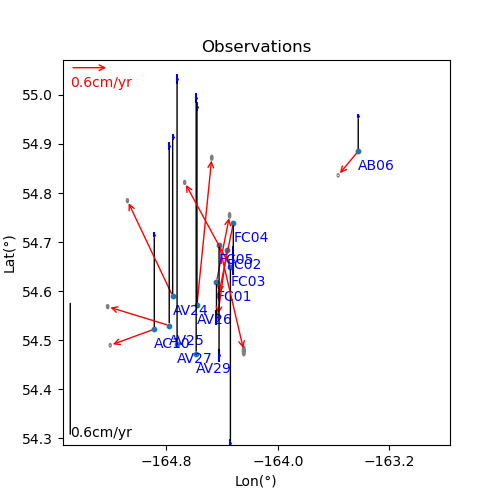

In [5]:
util.plot_gnss(lons,lats,uxs,uys,uzs,'Observations',names,euxs,euys,euzs,scl=0.6,unit='deg')

In [6]:
plt.imshow(qmap,extent=extent,vmin=-0.015,vmax=0.015,cmap='jet')
plt.colorbar(orientation='horizontal')

# InSAR (ascending) data object

Here we load the downsampled InSAR dataset into an Insar object

In [7]:
from vmod.data import Insar

#Creating observation object in this case an 
#InSAR dataset 
obsin_asc=Insar()

#Add azimuth and incidence angles
#obsin_asc.add_vecs(azs,lks)

#Add x and y coordinates
#obsin_asc.add_xs(xs)
#obsin_asc.add_ys(ys)

#Add LOS deformation data
#obsin_asc.add_los(los)

#Add reference point in (x,y) coordinates
#obsin_asc.add_ref(ref)

#Import csv into observation object
csvfile_ref='examples/insar/unimak_asc_ref.csv'
obsin_asc.importcsv(csvfile_ref,ori=[-164.5,54.7])

In [8]:
mask=np.load('examples/insar/mask_unimak_asc.npy')
csvfile='examples/insar/unimak_asc_ref.csv'
qmap,extent,rcoords=util.get_defmap(csvfile,mask=mask,trans=False)

# Plot GNSS dataset with ascending InSAR dataset

In [9]:
csvfile='examples/gps/unimak_gnss_NOAM.txt'
names,lons,lats,uxs,uys,uzs,euxs,euys,euzs=util.read_gnss_csv(csvfile,trans=False)

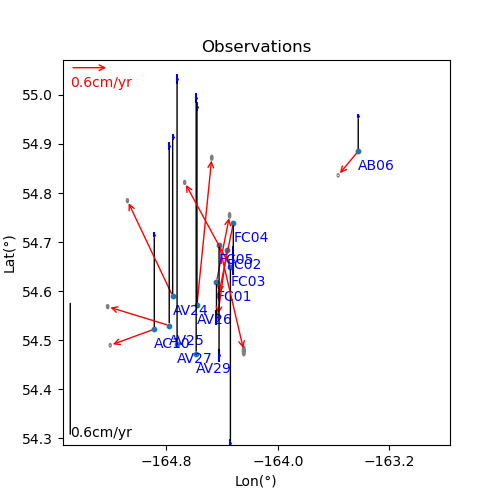

In [10]:
util.plot_gnss(lons,lats,uxs,uys,uzs,'Observations',names,euxs,euys,euzs,scl=0.6,unit='deg')

In [11]:
plt.imshow(qmap,extent=extent,vmin=-0.015,vmax=0.015,cmap='jet')
plt.colorbar(orientation='horizontal')

# Import GNSS dataset into a Gnss object

Here we import the csv file with the GNSS velocities and put it into a Gnss object

In [12]:
from vmod.data import Gnss

#Creating observation object in this case 
#an GNSS dataset 
obsg=Gnss()

#Add the names of the stations
#obsg.add_names(names)

#Add the x and y coordinates 
#of the stations
#obsg.add_xs(xs)
#obsg.add_ys(ys)

#Add deformation dataset in east (uxs), 
#north (uys) and vertical (uzs)
#obsg.add_ux(uxs)
#obsg.add_uy(uys)
#obsg.add_uz(uzs)

#Add uncertainties in east (euxs), 
#north (euys) and vertical (euzs)
#obsg.add_errx(euxs)
#obsg.add_erry(euys)
#obsg.add_errz(euzs)

#Import csv into the observation object
obsg.importcsv(csvfile,ori=[-164.5,54.7])
obsg.add_ref('AB06')

# Defining Joint dataset object

In this step, we create a Joint object with the InSAR dataset (ascending and descending) and the GNSS dataset

In [13]:
from vmod.data import Joint

#Creating observation object in 
#this case a Joint dataset
obs=Joint()

#Adding each dataset object, the 
#user has to provide the relative
#weight of each dataset
#obs.add_dataset(obsin_des,wt=wt_insar)
#obs.add_dataset(obsin_asc,wt=wt_insar)
#obs.add_dataset(obsg,wt=wt_gps)

obsin_asc.add_err(obsin_asc.err*0+1)
obsin_des.add_err(obsin_des.err*0+1)

obs.add_dataset(obsin_des,wt=1.0)
obs.add_dataset(obsin_asc,wt=1.0)
obs.add_dataset(obsg,wt=(len(obsin_des.xs)+len(obsin_asc.xs))/(10*len(obsg.xs)))

# Model and Inverse objects

Here we create the model and inverse objects to run the inversions. We created some auxiliary objects for plotting purposes.

In [14]:
from vmod.source import Mctigue
from vmod.source import Penny
from vmod.source import Okada
from vmod.source import Yang
from vmod.inverse import Inverse

################# Model objects just for plotting##########################################
ygg = Yang(obsg)
#Bounds for parameters
ygg.set_bounds(low_bounds = [0,0,1e3,-1e-2,1e3,1e3,0.1,0.1], high_bounds = [20000,20000,15e3,1e-2,7e3,7e3,359,89])


mctg = Mctigue(obsg)
#Bounds for parameters
mctg.set_bounds(low_bounds = [-20000,-20000,1e3,1e2,-1e-2], high_bounds = [0,0,15e3,5e3,1e-2])

invg=Inverse(obsg)

invg.register_source(ygg)
invg.register_source(mctg)

#invg.register_source(oksg)

okind_des = Okada(obsin_des)
okind_des.set_type('open')
#Bounds for parameters
okind_des.set_bounds(low_bounds = [-20000,-20000,1e3,1e1,1e1,-100,1,89], high_bounds = [20000,20000,30e3,3e4,3e4,1,359,89.9])

ygin_des = Yang(obsin_des)
#Bounds for parameters
ygin_des.set_bounds(low_bounds = [0,0,1e3,-1e-2,1e3,1e3,0.1,0.1], high_bounds = [20000,20000,15e3,1e-2,7e3,7e3,359,89])

mctin_des = Mctigue(obsin_des)
#Bounds for parameters
mctin_des.set_bounds(low_bounds = [-20000,-20000,1e3,1e2,-1e-2], high_bounds = [0,0,15e3,5e3,1e-2])

invin_des=Inverse(obsin_des)
#invin_des.register_source(okind_des)
invin_des.register_source(ygin_des)
invin_des.register_source(mctin_des)

okind_asc = Okada(obsin_asc)
okind_asc.set_type('open')
#Bounds for parameters
okind_asc.set_bounds(low_bounds = [-20000,-20000,1e3,1e1,1e1,-100,1,89], high_bounds = [20000,20000,30e3,3e4,3e4,1,359,89.9])

ygin_asc = Yang(obsin_asc)
#Bounds for parameters
ygin_asc.set_bounds(low_bounds = [-10000,-10000,1e3,-1e-2,1e3,1e3,0.1,0.1], high_bounds = [20000,20000,15e3,1e-2,7e3,7e3,359,89])

mctin_asc = Mctigue(obsin_asc)
#Bounds for parameters
mctin_asc.set_bounds(low_bounds = [-20000,-20000,1e3,1e2,-1e-2], high_bounds = [0,0,15e3,5e3,1e-2])

invin_asc=Inverse(obsin_asc)

invin_asc.register_source(ygin_asc)
invin_asc.register_source(mctin_asc)

################# Model objects just for plotting##########################################

################# Model objects for Joint dataset##########################################
yg = Yang(obs)
#Bounds for parameters
yg.set_bounds(low_bounds = [-3e4,-3e4,1e3,-1e-2,1e2,1e2,0.1,0.1], high_bounds = [3e4,3e4,15e3,1e-2,20e3,7e3,359,89])

#Creating model object in this case a spherical source
mct = Mctigue(obs)
#The parameters are location (x,y), depth, radius and volume change
#Bounds for parameters
mct.set_bounds(low_bounds = [-3e4,-3e4,1e3,1e2,-1e-2], high_bounds = [3e4,3e4,15e3,5e3,1e-2])

inv=Inverse(obs)

inv.register_source(yg)
inv.register_source(mct)
################# Model objects for Joint dataset##########################################

# Non-linear least squares inversion

In this step we run the non-linear least squares inversion and print the results

In [15]:
params=inv.nlsq()

  2%|▏         | 1/64 [00:38<40:32, 38.61s/it]/home/jovyan/notebooks/ASF/vmod_git2/vmod/vmod/source/yang.py:127: RuntimeWarning: invalid value encountered in sqrt
  c = np.sqrt(a ** 2 - b ** 2)
100%|██████████| 64/64 [32:14<00:00, 30.23s/it] 


In [16]:
parnames,orders=inv.get_parnames_orders()
for i,parname in enumerate(parnames):
    print(parname,params[i])

xcen0 8431.365015392772
ycen0 -3445.508790916207
depth0 4186.262019891731
pressure0 -0.009951178772463702
a0 535.4143145873816
b0 287.4698050976372
az0 90.59800372691198
dip0 84.31598923927118
xcen1 -9527.955692356982
ycen1 -19909.585946180534
depth1 7224.973453679035
radius1 853.6926007715755
dP1 0.002524739281537568


## Plotting results from nlsq

Here we use the auxiliary objects to plot the results from the nlsq inversion

In [17]:
los_des=invin_des.forward(params)
los_asc=invin_asc.forward(params)

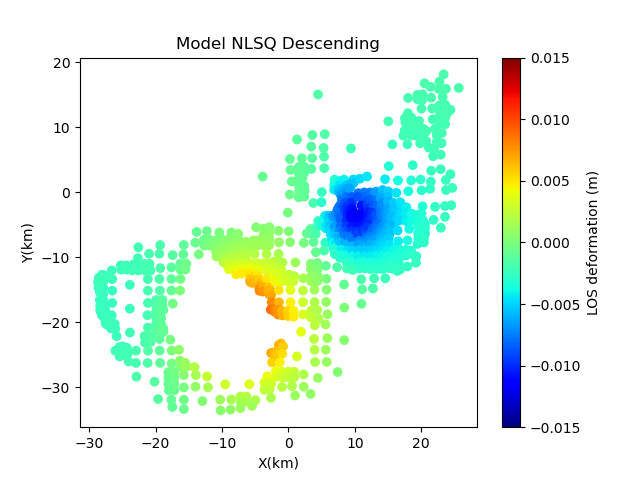

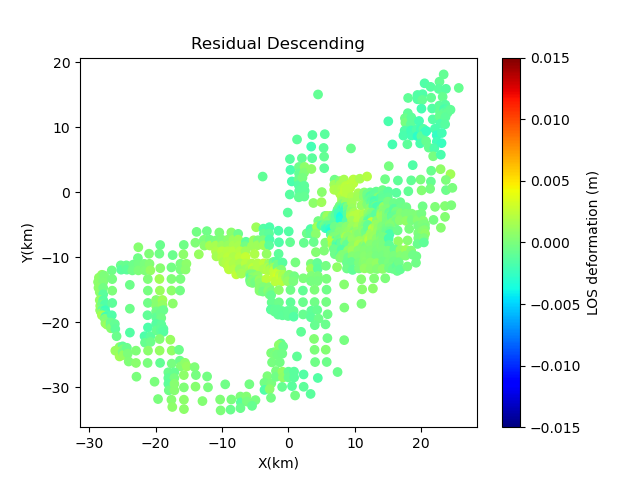

In [18]:
plt.figure()
plt.title('Model NLSQ Descending')
plt.scatter(obsin_des.xs/1e3,obsin_des.ys/1e3,c=los_des,cmap='jet',vmin=-0.015,vmax=0.015)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(label='LOS deformation (m)')

plt.figure()
plt.title('Residual Descending')
plt.scatter(obsin_des.xs/1e3,obsin_des.ys/1e3,c=obsin_des.get_data()-los_des,cmap='jet',vmin=-0.015,vmax=0.015)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(label='LOS deformation (m)')

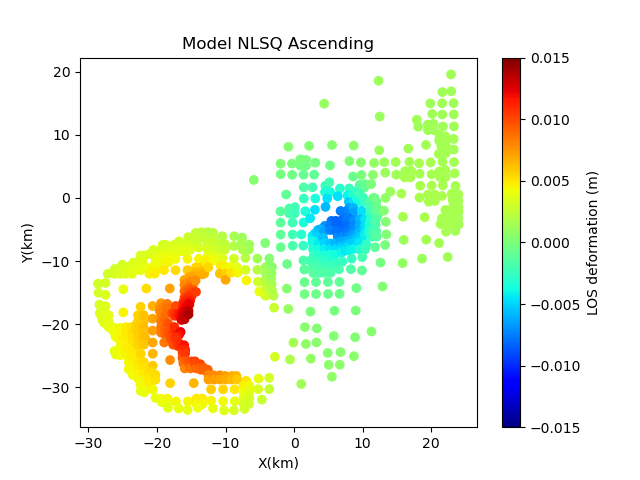

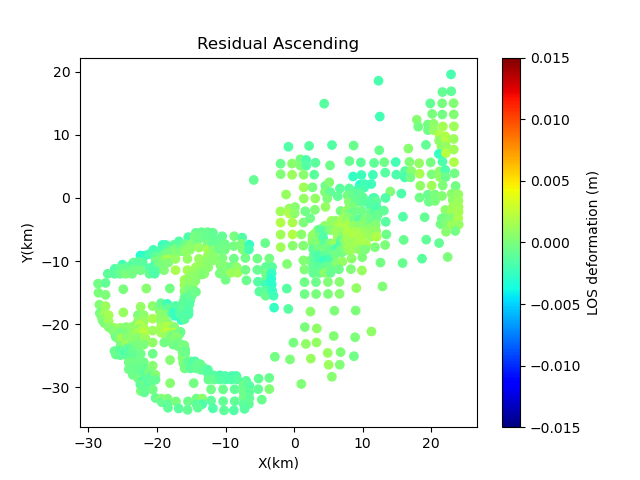

In [19]:
plt.figure()
plt.title('Model NLSQ Ascending')
plt.scatter(obsin_asc.xs/1e3,obsin_asc.ys/1e3,c=los_asc,cmap='jet',vmin=-0.015,vmax=0.015)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(label='LOS deformation (m)')

plt.figure()
plt.title('Residual Ascending')
plt.scatter(obsin_asc.xs/1e3,obsin_asc.ys/1e3,c=obsin_asc.get_data()-los_asc,cmap='jet',vmin=-0.015,vmax=0.015)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(label='LOS deformation (m)')

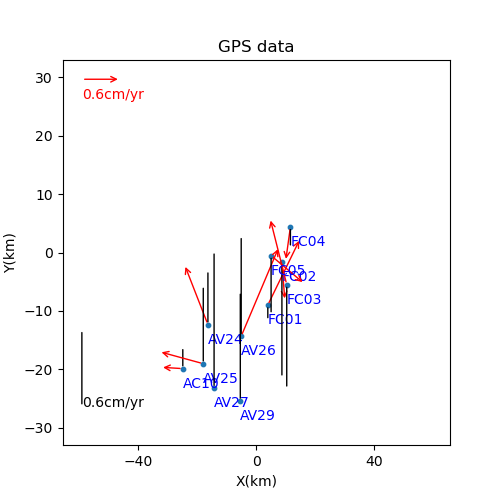

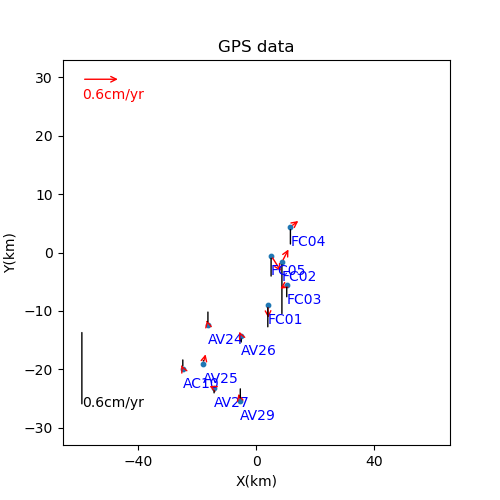

In [21]:
uxsm,uysm,uzsm=invg.forward(params,unravel=False)

uxs,uys,uzs=obsg.get_data(unravel=False)

util.plot_gnss(obsg.xs,obsg.ys,uxsm,uysm,uzsm,names=names,scl=0.6)

util.plot_gnss(obsg.xs,obsg.ys,uxs-uxsm,uys-uysm,uzs-uzsm,names=names,scl=0.6)

# Bayesian inversion

When we run the next cell the Bayesian inversion will start

In [ ]:
trace=inv.mcmc_em('unimak_joint_smc')

[np.float64(8.431365015392773), np.float64(-3.445508790916207), np.float64(4.186262019891731), np.float64(-0.9951178772463702), np.float64(0.5354143145873815), np.float64(2.874698050976372), np.float64(9.059800372691198), np.float64(84.31598923927118), np.float64(-9.527955692356981), np.float64(-19.909585946180535), np.float64(7.224973453679035), np.float64(8.536926007715754), np.float64(2.5247392815375678), 0.0]


 24%|██▍       | 57485/235714 [2:33:01<7:31:16,  6.58it/s] 

The traces from the Bayesian inversion are stored in a .pkl file

In [25]:
import pickle
with open('unimak_joint_smc.pkl','rb') as handle:
    dic=pickle.load(handle)

trace=[dic[key] for key in dic.keys()]

## Plotting results from Bayesian inversion

Here we use the corner library to plot the posterior distributions and we use the auxiliary objects to plot the results

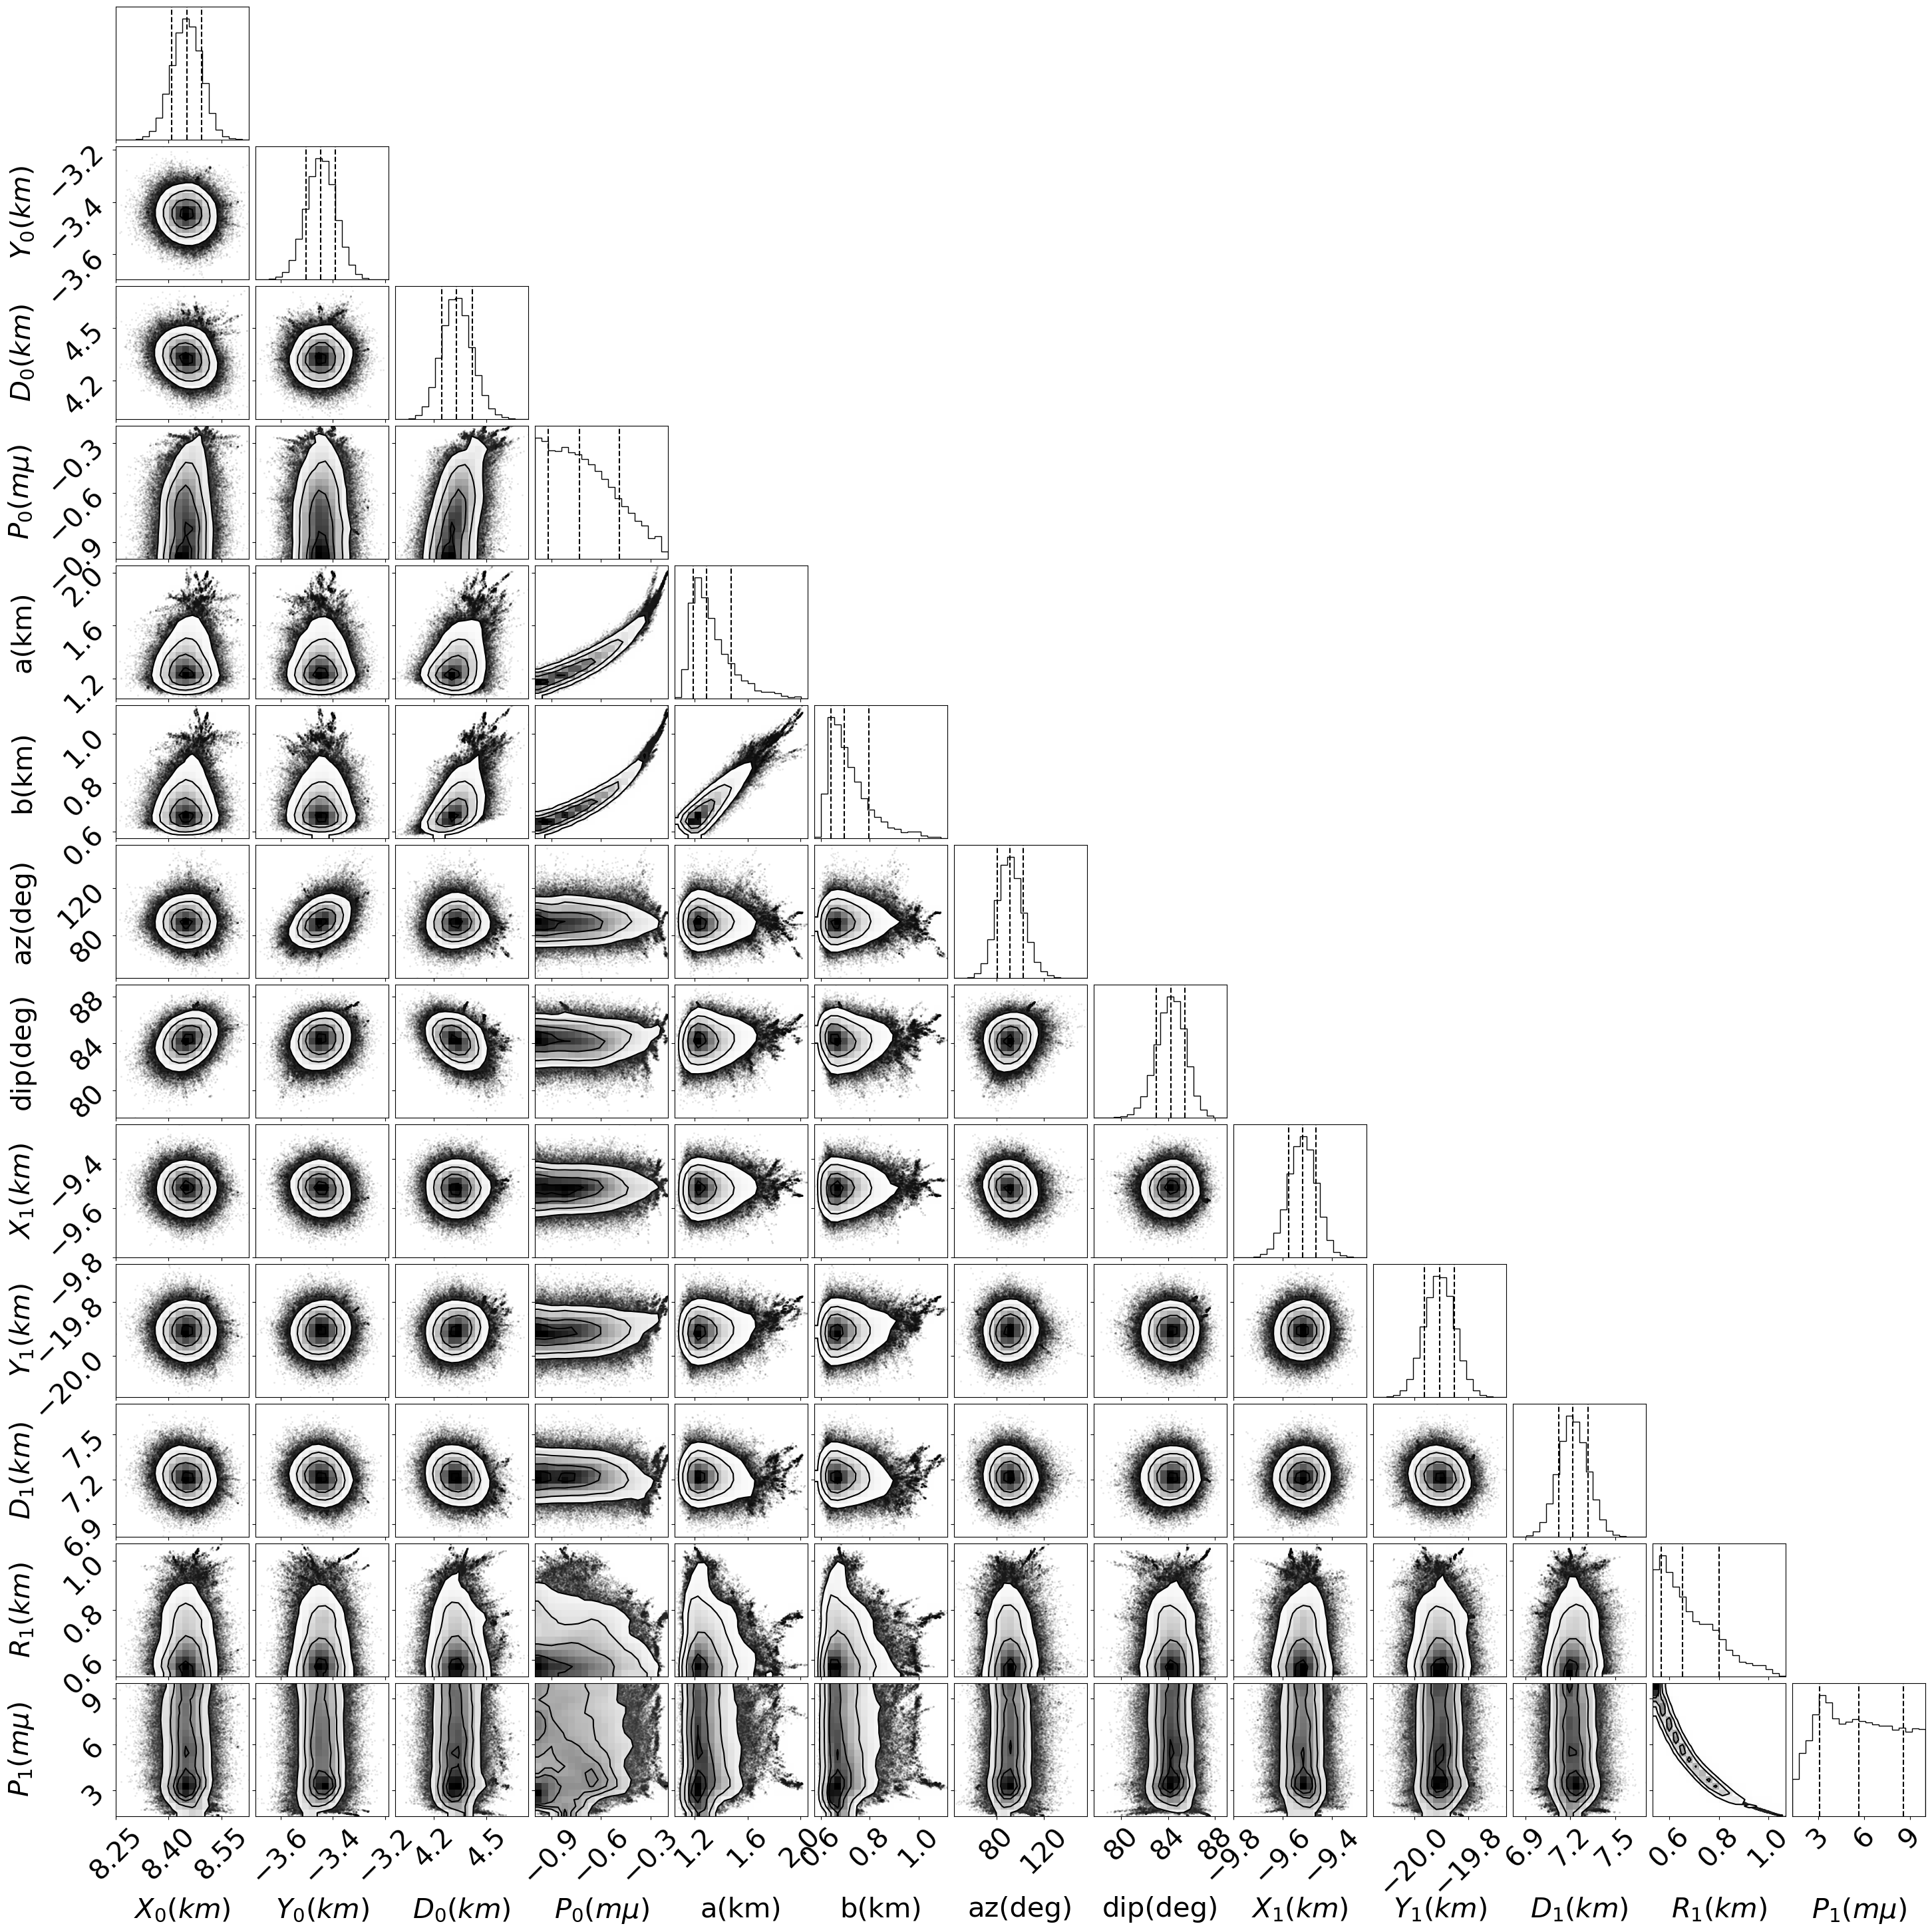

In [28]:
%matplotlib inline
data=[]
labels=[]
parnames,orders=inv.get_parnames_orders()
for i,tr in enumerate(trace):
    data.append(tr[:])
    labels.append(parnames[i])
data=np.vstack(data)
newdata=np.copy(data)

newdata[0:3,:]=newdata[0:3]/1e3
newdata[3,:]=newdata[3,:]*1e3
newdata[4:6,:]=newdata[4:6,:]/1e3
newdata[8:12,:]=newdata[8:12,:]/1e3
newdata[12,:]=newdata[12,:]*1e3

newlabels=[r'$X_{0} (km)$',r'$Y_{0} (km)$',r'$D_{0}(km)$',r'$P_{0} (m\mu)$','a(km)','b(km)','az(deg)','dip(deg)',r'$X_{1} (km)$',r'$Y_{1} (km)$',r'$D_{1}(km)$',r'$R_{1}(km)$',r'$P_{1} (m\mu)$']

plt.rcParams.update({'font.size': 30})

figure = corner.corner(newdata.T, labels=newlabels,max_n_ticks=3,smooth=0.7,labelpad=0.3,
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=False, title_kwargs={"fontsize": 30})
plt.savefig('histograms')

In [29]:
bl=np.array([np.percentile(data[i,:],5) for i in range(data.shape[0])])
bh=np.array([np.percentile(data[i,:],95) for i in range(data.shape[0])])

import copy

obsn=Joint()

obs_ascn=copy.deepcopy(obsin_asc)
obs_ascn.add_err(obs_ascn.err*0+1)
obs_desn=copy.deepcopy(obsin_des)
obs_desn.add_err(obs_desn.err*0+1)

obsn.add_dataset(obs_ascn,wt=1.0)
obsn.add_dataset(obs_desn,wt=1.0)

ygn = Yang(obsn)
#Bounds for parameters
ygn.set_bounds(low_bounds = bl[0:8], high_bounds = bh[0:8])

mctn = Mctigue(obsn)
#Bounds for parameters
mctn.set_bounds(low_bounds = bl[8::], high_bounds = bh[8::])

invb=Inverse(obsn)
invb.register_source(ygn)
invb.register_source(mctn)

In [30]:
paramsn=invb.nlsq()

100%|██████████| 64/64 [03:02<00:00,  2.85s/it]


In [31]:
parnames,orders=invb.get_parnames_orders()
for i,parname in enumerate(parnames):
    print(parname,paramsn[i])

xcen0 8473.621274230443
ycen0 -3415.5125622484334
depth0 4375.400679867488
pressure0 -0.0008413723989579143
a0 1236.4320813758873
b0 662.5785987033119
az0 85.64549439069695
dip0 84.69294232820153
xcen1 -9533.946495268521
ycen1 -19876.64080319086
depth1 7269.314054030862
radius1 598.249433229185
dP1 0.0072122664046932305


10.891404993267846 895


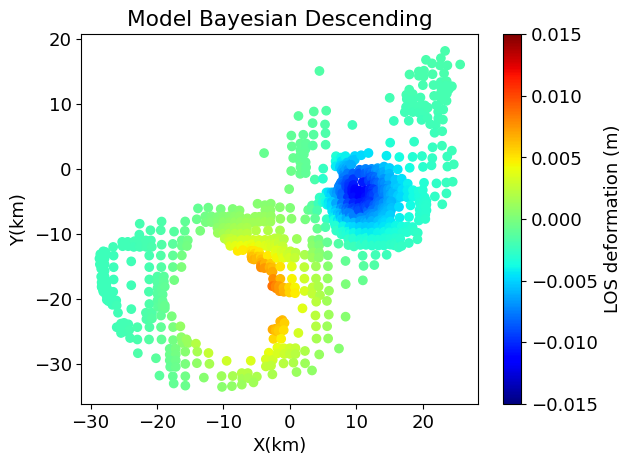

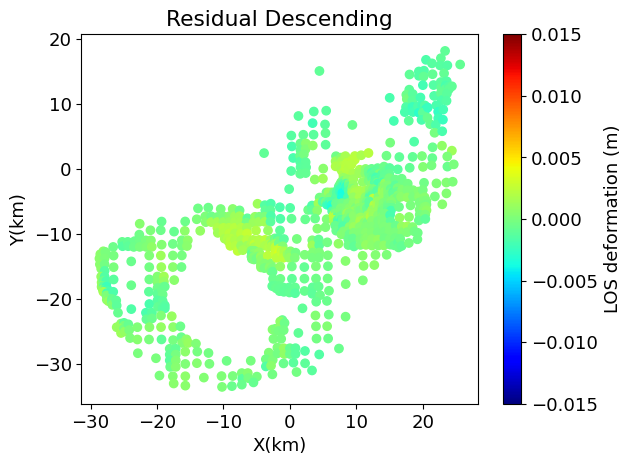

In [32]:
los_des=invin_des.forward(paramsn)

plt.rcParams.update({'font.size': 13})

plt.figure()
plt.title('Model Bayesian Descending')
plt.scatter(obsin_des.xs/1e3,obsin_des.ys/1e3,c=los_des,cmap='jet',vmin=-0.015,vmax=0.015)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(label='LOS deformation (m)')

plt.figure()
plt.title('Residual Descending')
plt.scatter(obsin_des.xs/1e3,obsin_des.ys/1e3,c=obsin_des.get_data()-los_des,cmap='jet',vmin=-0.015,vmax=0.015)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(label='LOS deformation (m)')

print(np.sum(((obsin_des.get_data()-los_des)*1e2)**2),len(los_des))

8.512181789961389 800


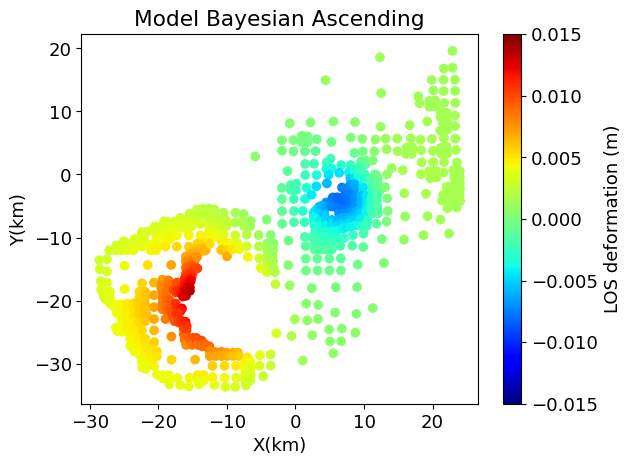

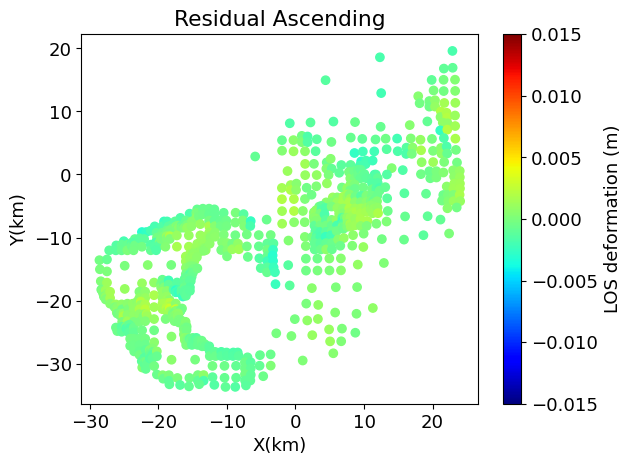

In [33]:
los_asc=invin_asc.forward(paramsn)

plt.figure()
plt.title('Model Bayesian Ascending')
plt.scatter(obsin_asc.xs/1e3,obsin_asc.ys/1e3,c=los_asc,cmap='jet',vmin=-0.015,vmax=0.015)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(label='LOS deformation (m)')

plt.figure()
plt.title('Residual Ascending')
plt.scatter(obsin_asc.xs/1e3,obsin_asc.ys/1e3,c=obsin_asc.get_data()-los_asc,cmap='jet',vmin=-0.015,vmax=0.015)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(label='LOS deformation (m)')

print(np.sum(((obsin_asc.get_data()-los_asc)*1e2)**2),len(los_asc))

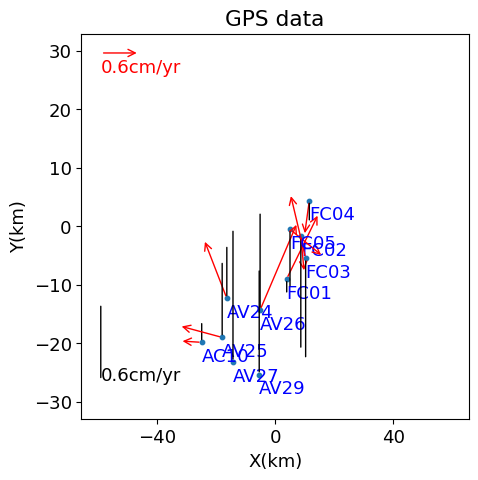

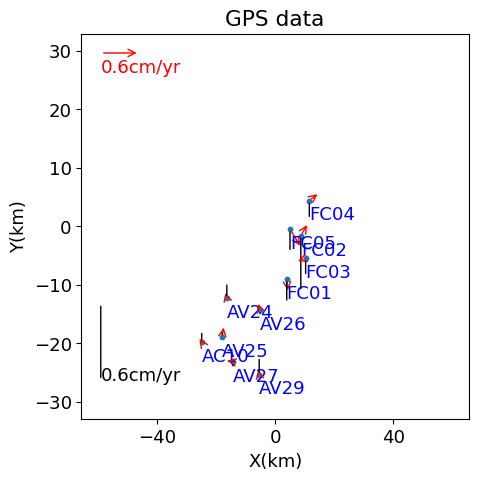

0.5381007702839429


In [35]:
%matplotlib inline
uxsm,uysm,uzsm=invg.forward(paramsn,unravel=False)

uxs,uys,uzs=obsg.get_data(unravel=False)

util.plot_gnss(obsg.xs,obsg.ys,uxsm,uysm,uzsm,names=names,scl=0.6)
#plt.title('Model Bayesian GPS')

util.plot_gnss(obsg.xs,obsg.ys,uxs-uxsm,uys-uysm,uzs-uzsm,names=names,scl=0.6)
#plt.title('Residuals GPS')

print(np.sum((uxs*1e2-uxsm*1e2)**2+(uys*1e2-uysm*1e2)**2+(uzs*1e2-uzsm*1e2)**2))